# Clustering

Ya vimos en clase el método **BFR**, pero sabemos que a pesar de ser muy eficiente tiene muchos supuestos. Si queremos manejar Big Data pero además permitir que los clusters no tengan restricción en su forma debemos usar algo como el algoritmo **CURE**. Por esto nos concentraremos en este algoritmo.

Para asegurarnos que la forma arbitraria se pueda dar, recomiendo usar el generador de datasets de lunas (`sklearn.datasets.make_moons`). Recomiendo usar un `n_samples` pequeño durante las pruebas y después crecerlo para ver si todo funciona correctamente.

### Importando Librerías

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons
import dbcv
from collections import Counter
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.metrics import pairwise_distances_argmin_min, euclidean_distances, pairwise_distances_argmin, accuracy_score

### Cargando y visualizando Datasets

**Nota:** A pesar de que el dataset de moons tiene etiquetas, para efectos el ejercicio se van a ingnorar las etiquetas dado que estamos en un escenario de clustering no supervisado. (en la vida real no tenemos los datos etiquetados)

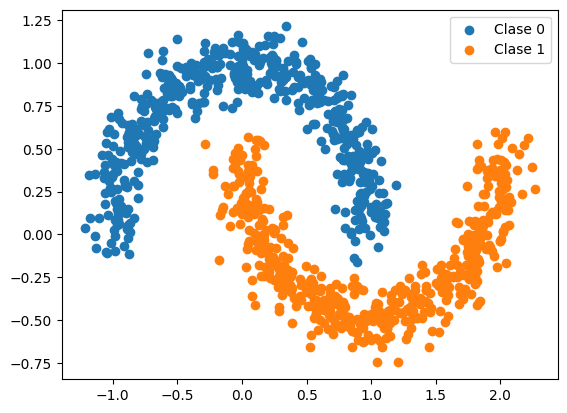

In [2]:
# Cargando datos
np.random.seed(42)

n_samples = 1000
noisy_moons = make_moons(n_samples=n_samples, noise=.1)
X = noisy_moons[0] # X[n_samples, 0:2]
y = noisy_moons[1] # y[n_samples] = clases (si quiere evaluar)


# Graficar por clases
cls0 = (y == 0)
cls1 = (y == 1)
plt.scatter(X[cls0,0], X[cls0,1], label='Clase 0')
plt.scatter(X[cls1,0], X[cls1,1], label='Clase 1')
plt.legend()
plt.show()

## Pasada 1

En la primera pasada debemos hacer clusters con una muestra aleatoria para tener una partida.
Use su librería favorita para hacer dos (2) clusters con una muestra de los datos y escoja los puntos representativos de cada uno (4 estaría bien).

Al final use el parámetro `alpha = 0.2` (20%) para acercar los valores representativos al centroide.

### Generando y visualizando muestra aleatoria

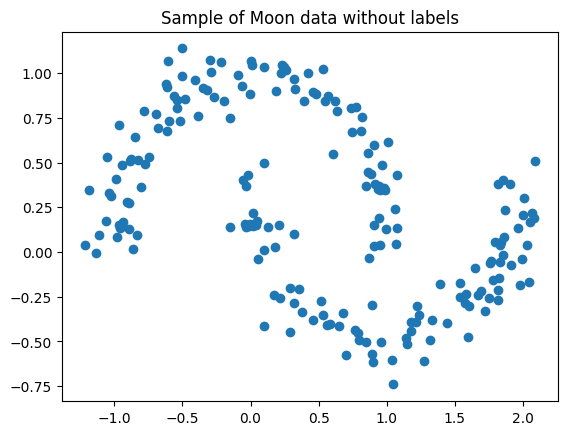

In [3]:
# Tomar una muestra aleatoria
sample_indices = np.random.choice(len(X), size=int(len(noisy_moons[0])*0.2), replace=False)
X_sample = X[sample_indices]
y_sample = y[sample_indices]

# Graficar muestra por clases
plt.figure('Sample of Moon Data')
plt.scatter(X_sample[:, 0], X_sample[:, 1])
plt.title('Sample of Moon data without labels')
plt.show()

### Realizando Clusterización con Muestra

Se van a probar diferentes modelos de clusterización sobre la muestra y se va a seleccionar el que mejor desempeño tenga para usarlo como referencia en la **Primera pasada** del algoritmo `CUFE`

Dado que los datos son no convexos, es probable que las técnicas tradicionales como `k-means` no sean la mejor opción. Para este tipo de datos una buena alternativa es `BDSCAN`.

Sin embargo, vamos a comparar `k-means`, `clustering jerarquico` y `BDSCAN`

#### Modelos

In [4]:
# Aplicar modelos

# Aplicar KMeans
num_clusters_kmeans = 2
kmeans = KMeans(n_clusters=num_clusters_kmeans, random_state=42)
kmeans_labels = kmeans.fit_predict(X_sample)

# Aplicar DBSCAN
eps_dbscan = 0.25  # Radio de la vecindad
min_samples_dbscan = 5  # Número mínimo de puntos en una vecindad para formar un cluster
dbscan = DBSCAN(eps=eps_dbscan, min_samples=min_samples_dbscan)
dbscan_labels = dbscan.fit_predict(X_sample)

# Aplicar clustering jerárquico
num_clusters_hierarchical = 2
hierarchical = AgglomerativeClustering(n_clusters=num_clusters_hierarchical)
hierarchical_labels = hierarchical.fit_predict(X_sample)


#### Visualización

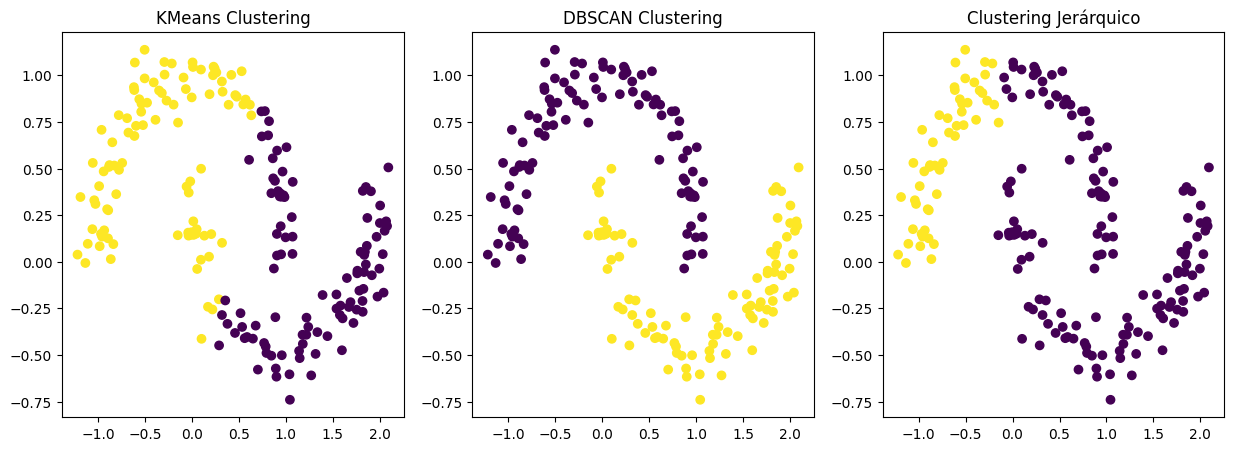

In [5]:
plt.figure('Comparacion',figsize=(15, 5))

plt.subplot(131)
plt.scatter(X_sample[:, 0], X_sample[:, 1], c=kmeans_labels)
plt.title('KMeans Clustering')

plt.subplot(132)
plt.scatter(X_sample[:, 0], X_sample[:, 1], c=dbscan_labels)
plt.title('DBSCAN Clustering')

plt.subplot(133)
plt.scatter(X_sample[:, 0], X_sample[:, 1], c=hierarchical_labels)
plt.title('Clustering Jerárquico')

plt.show()

#### Métricas de Validación

La elección de una buena métrica de validación es indispensable para tomar una buena decisión respecto al modelo. Dado que es un proceso no supervisado porque no se conocen las etiquetas reales, no podemos calcular métricas como el Accuracy. 

Para un proceso de clustering, existen varias métricas y su elección depende de si tenemos datos convexos o no convexos.

Para datos convexos se deben usar:
- **Coeficiente se silueta** : Los valores más cercanos a 1 indican una mejor partición de los datos.
- **Davies-Bouldin Index**: Los valores más cercanos a cero indican una mejor partición.

Para datos no convexos, como los que tenemos en este caso, se debe usar **Density-Based Cluster Validation (DBCV)**. Esta métrica toma valores entre -1 y 1. Se interpreta de la siguiente manera:
- Valores cercanos a 1 indican que están bien definidos los clusters y separados entre sí, con alta densidad dentro de cada clúster.
- Valores cercanos a 0: Sugiere que los clústeres no están claramente separados o que los puntos dentro de los clústeres no tienen una densidad significativamente mayor que los puntos en los bordes de los clústeres.
- Valores negativos: Indica que los clústeres están mal definidos, con baja densidad dentro de los clústeres y/o alta densidad entre clústeres.

In [6]:
agg_score = dbcv.dbcv(X_sample, hierarchical_labels)
kmeans_score = dbcv.dbcv(X_sample, kmeans_labels)
hdbscan_score = dbcv.dbcv(X_sample, dbscan_labels)

print(f'DBCV Score para Clusterización Jerarquica {agg_score}')
print(f'DBCV Score para Clusterización con K-Means {kmeans_score}')
print(f'DBCV Score para Clusterización con DBScan {hdbscan_score}')

DBCV Score para Clusterización Jerarquica -0.4232347254644057
DBCV Score para Clusterización con K-Means -0.7520594723998283
DBCV Score para Clusterización con DBScan 0.7725421625762832


De acuerdo con la visualización del clustering y la métrica de **DBCV** se puede concluir que el mejor modelo para la primera pasada es `BDSCAN`.

### Centroides y puntos representativos de cada cluster

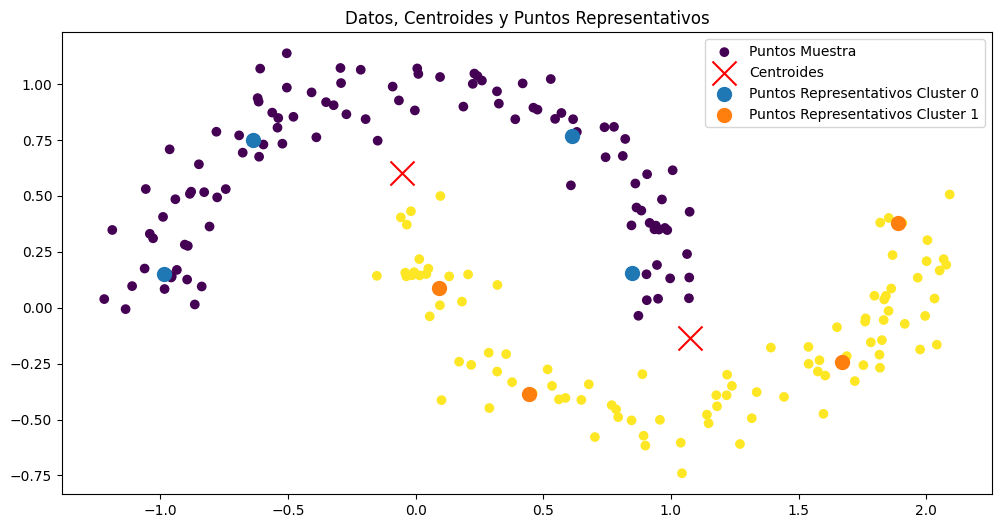

In [7]:
# Función para calcular el centroide
def compute_centroid(points):
    return np.mean(points, axis=0)

# Función para mover un punto hacia el centroide
def move_towards_centroid(point, centroid, alpha=0.2):
    return point + alpha * (centroid - point)

# Función para seleccionar puntos representativos iterativamente
def select_representative_points(cluster_points, centroid, num_points=4):
    selected_points = []
    for _ in range(num_points):
        if not selected_points:
            # Seleccionar el punto más lejano al centroide en la primera iteración
            distances = euclidean_distances(cluster_points, centroid.reshape(1, -1)).flatten()
        else:
            # Seleccionar el punto más lejano al conjunto de puntos seleccionados
            distances = euclidean_distances(cluster_points, np.vstack([centroid] + selected_points)).min(axis=1)
        farthest_index = np.argmax(distances)
        selected_points.append(cluster_points[farthest_index])
        cluster_points = np.delete(cluster_points, farthest_index, axis=0)
    return np.array(selected_points)

## Identificar los clusters únicos
unique_labels = set(dbscan_labels)


# Calcular los centroides de cada cluster
centroids = []
representative_points = []
alpha = 0.2

for label in unique_labels:
    cluster_points = X_sample[dbscan_labels == label]
    centroid = compute_centroid(cluster_points)
    centroids.append(centroid)

    # Seleccionar puntos representativos iterativamente
    farthest_points = select_representative_points(cluster_points, centroid, num_points=4)

    # Mover puntos representativos hacia el centroide
    moved_points = np.array([move_towards_centroid(p, centroid, alpha) for p in farthest_points])
    representative_points.append((moved_points, label))

centroids = np.array(centroids)

# Graficar resultados
plt.figure(figsize=(12, 6))

# Gráfico de datos, centroides y puntos representativos
plt.scatter(X_sample[:, 0], X_sample[:, 1], c=dbscan_labels, cmap='viridis', marker='o', label='Puntos Muestra')
plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='red', marker='x', label='Centroides')
for points, label in representative_points:
    plt.scatter(points[:, 0], points[:, 1], s=100, marker='o', label=f'Puntos Representativos Cluster {label}')
plt.title('Datos, Centroides y Puntos Representativos')
plt.legend()

plt.show()

## Pasada 2

En la segunda pasada simplemente se concentra en que cada dato tenga su cluster asignado. Esto es sencillo, solamente tenga una lista de los valores representativos y encuentre la distancia más cercana al punto deseado. El valor representativo más cercano dictará el cluster al que pertenece.

Asigne y muestre una gráfica similar a la del comienzo para revisar cuáles fueron los clusters asignados.

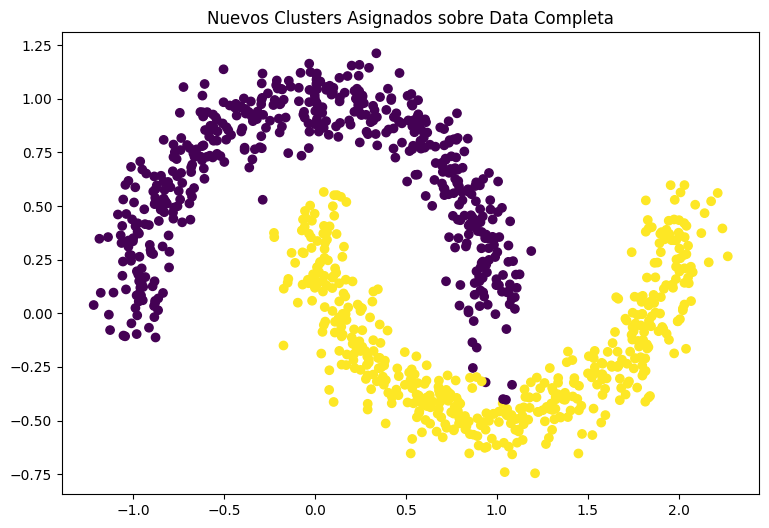

In [8]:
# Concatenar todos los puntos representativos y sus etiquetas
rep_points = np.concatenate([points for points, _ in representative_points])
rep_labels = np.concatenate([[label] * len(points) for points, label in representative_points])

# Asignar cada punto de la muestra completa al clúster del punto representativo más cercano
assigned_labels = pairwise_distances_argmin(X, rep_points)

# Asignar etiquetas de clúster basadas en los puntos representativos más cercanos
new_labels = rep_labels[assigned_labels]

# Graficar resultados de la segunda pasada
plt.figure(figsize=(9, 6))

# Gráfico de datos con nuevos clusters asignados
plt.scatter(X[:, 0], X[:, 1], c=new_labels, cmap='viridis', marker='o')
plt.title('Nuevos Clusters Asignados sobre Data Completa')

plt.show()

## Validación de Resultados

Aunque este es un caso no supervisado, con fines académicos, se van a aprovechar las etiquetas que tiene la data generada para validar la precisión del método para la clasificación de toda la data.

In [9]:
# Calcular la precisión
accuracy = accuracy_score(y, new_labels)

# Mostrar la precisión
print(f'Accuracy of CUFE clustering: {accuracy*100:.2f}%')

Accuracy of CUFE clustering: 99.40%


## Experimentación

### Función para el proceso

In [15]:
def cufe_model(size_dataset:int, percentage_to_sample:float, epsilon_dbscan:float, min_samples_dbscan:int, alpha_cufe: float):

    """
    Aplica el método CUFE para clusterización sobre un dataset sintético de lunas.

    Parámetros:size_dataset:int, percentage_to_sample:float, epsilon_dbscan:float, min_samples_bdscan:int, alpha_cufe: float
    - size_dataset: int, tamaño del dataset a generar.
    - percentage_to_sample: float, porcentaje del dataset a usar como muestra.
    - epsilon_dbscan: float, valor epsilon para el algoritmo DBSCAN.
    - min_samples_dbscan: int, número mínimo de muestras para formar un clúster en DBSCAN.
    - alpha_cufe: float, factor de ajuste para mover puntos representativos hacia el centroide.
    """

    # ========================== Dataset ===================================================

    # Cargando datos
    np.random.seed(42)  
    n_samples = size_dataset
    noisy_moons = make_moons(n_samples=n_samples, noise=.1)
    X = noisy_moons[0] 
    y = noisy_moons[1] 


    # Tomar una muestra aleatoria
    sample_indices = np.random.choice(len(X), size=int(len(noisy_moons[0])*percentage_to_sample), replace=False)
    X_sample = X[sample_indices]
    y_sample = y[sample_indices]


    print(f"Parametros modelo CUFE: ")
    print(f"size_dataset: {size_dataset}")
    print(f"percentage_to_sample: {percentage_to_sample}")
    print(f"epsilon_dbscan: {epsilon_dbscan}")
    print(f"min_samples_dbscan: {min_samples_dbscan}")
    print(f"alpha_cufe: {alpha_cufe}\n")

    # ============================== Pasada 1 ===============================================

    # Aplicar DBSCAN
    eps_dbscan = epsilon_dbscan  # Radio de la vecindad
    min_samples_dbscan = min_samples_dbscan  # Número mínimo de puntos en una vecindad para formar un cluster
    dbscan = DBSCAN(eps=eps_dbscan, min_samples=min_samples_dbscan)
    dbscan_labels = dbscan.fit_predict(X_sample)

    # Calcular el puntaje DBCV para la muestra
    hdbscan_score = dbcv.dbcv(X_sample, dbscan_labels)
    print(f'DBCV Score para Clusterización con DBScan {hdbscan_score}')

    # Identificar los clusters únicos
    unique_labels = set(dbscan_labels)

    # Calcular los centroides y puntos representativos para cada clúster
    centroids = []
    representative_points = []
    alpha = alpha_cufe

    for label in unique_labels:
        cluster_points = X_sample[dbscan_labels == label]
        centroid = compute_centroid(cluster_points)
        centroids.append(centroid)
        farthest_points = select_representative_points(cluster_points, centroid, num_points=4)
        moved_points = np.array([move_towards_centroid(p, centroid, alpha) for p in farthest_points])
        representative_points.append((moved_points, label))

    centroids = np.array(centroids)


    # ============================== Pasada 2 ===============================================

    # Concatenar todos los puntos representativos y sus etiquetas
    rep_points = np.concatenate([points for points, _ in representative_points])
    rep_labels = np.concatenate([[label] * len(points) for points, label in representative_points])

    # Asignar cada punto de la muestra completa al clúster del punto representativo más cercano
    assigned_labels = pairwise_distances_argmin(X, rep_points)

    # Asignar etiquetas de clúster basadas en los puntos representativos más cercanos
    new_labels = rep_labels[assigned_labels]

    # Graficar resultados de la segunda pasada
    plt.figure(figsize=(7, 5))
    plt.scatter(X[:, 0], X[:, 1], c=new_labels, cmap='viridis', marker='o')
    plt.title('Nuevos Clusters Asignados sobre Data Completa')
    plt.show()

    # Evaluar la precisión
    accuracy = accuracy_score(y, new_labels)
    print(f'Accuracy of CUFE clustering: {accuracy*100:.2f}%\n')
    print(f'==================================================')

Parametros modelo CUFE: 
size_dataset: 1000
percentage_to_sample: 0.2
epsilon_dbscan: 0.25
min_samples_dbscan: 5
alpha_cufe: 0.1

DBCV Score para Clusterización con DBScan 0.7725421625762832


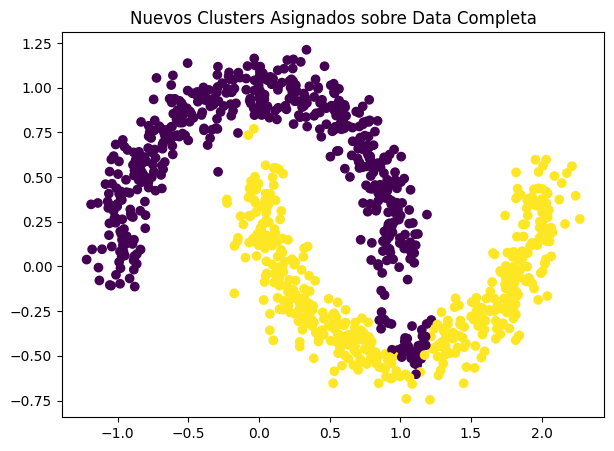

Accuracy of CUFE clustering: 96.00%

Parametros modelo CUFE: 
size_dataset: 1000
percentage_to_sample: 0.2
epsilon_dbscan: 0.25
min_samples_dbscan: 5
alpha_cufe: 0.2

DBCV Score para Clusterización con DBScan 0.7725421625762832


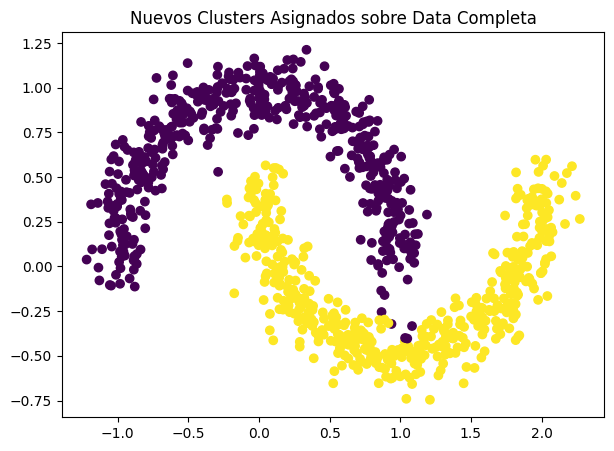

Accuracy of CUFE clustering: 99.40%

Parametros modelo CUFE: 
size_dataset: 1000
percentage_to_sample: 0.2
epsilon_dbscan: 0.25
min_samples_dbscan: 5
alpha_cufe: 0.3

DBCV Score para Clusterización con DBScan 0.7725421625762832


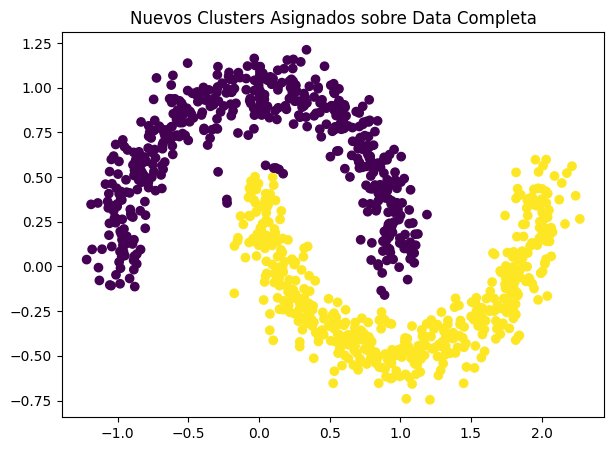

Accuracy of CUFE clustering: 99.20%

Parametros modelo CUFE: 
size_dataset: 1000
percentage_to_sample: 0.2
epsilon_dbscan: 0.25
min_samples_dbscan: 5
alpha_cufe: 0.5

DBCV Score para Clusterización con DBScan 0.7725421625762832


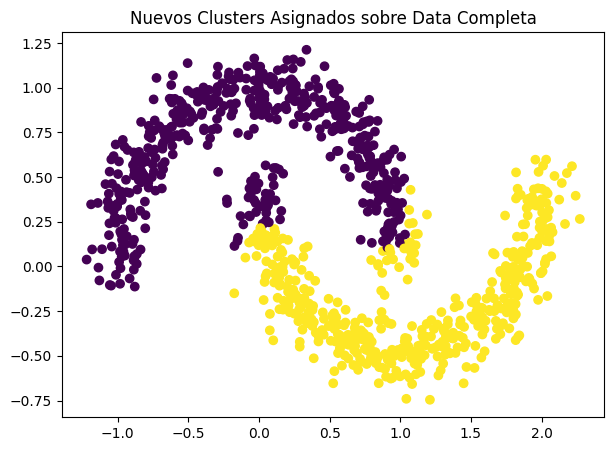

Accuracy of CUFE clustering: 92.70%

Parametros modelo CUFE: 
size_dataset: 1000
percentage_to_sample: 0.2
epsilon_dbscan: 0.25
min_samples_dbscan: 5
alpha_cufe: 0.8

DBCV Score para Clusterización con DBScan 0.7725421625762832


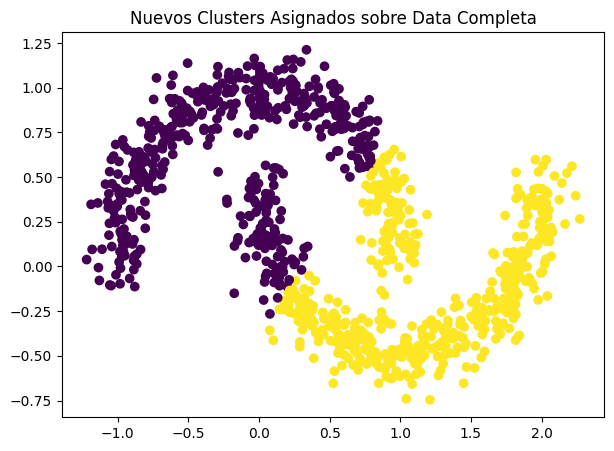

Accuracy of CUFE clustering: 79.80%



In [17]:
for i in [0.1,0.2,0.3,0.5,0.8]:
    cufe_model(
        size_dataset=1000,
        percentage_to_sample=0.2,
        epsilon_dbscan=0.25,
        min_samples_dbscan=5,
        alpha_cufe=i
    )